In [1]:
#!pip install gmusicapi
from gmusicapi import Mobileclient,Webclient,Musicmanager
from gmusicapi.utils import utils
print (utils.log_filepath)
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import keras as ks
from matplotlib import pyplot as plt
%matplotlib inline
import requests
import gensim
# !pip install tqdm
from tqdm import tqdm_notebook as tqdm
import sklearn as sk

import sklearn.preprocessing
import sklearn.ensemble
import sklearn.cluster

from sklearn import neural_network

import json

import sklearn.decomposition

import sklearn.mixture

/Users/aduriseti/Library/Logs/gmusicapi/gmusicapi.log


Using TensorFlow backend.
/Users/aduriseti/anaconda/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
email = 'aduriseti@gmail.com'
pswd = 'ehshpxjlzaaoknix'

api = Mobileclient(debug_logging=False)
api.login(email,pswd,api.FROM_MAC_ADDRESS)
# testsongid = api.get_all_songs()[0]['id']
# # api.get_stream_url(testsongid)

# for device in api.get_registered_devices():
#     api.logout()
#     api.login(email,pswd,device['id'].replace(':',''))
#     try:
#         api.get_stream_url(testsongid)
#         print('DEVICE',device['id'],'AUTHORIZED')
#         break
#     except:
#         print('DEVICE',device['id'],'NOT AUTHORIZED')

True

In [11]:
api.get_all_stations()

CallFailure: ListStations: 500 Server Error: Internal Server Error for url: https://mclients.googleapis.com/sj/v2.5/radio/station?alt=json&include-tracks=true&updated-min=-1&hl=en_US&tier=aa&dv=0
(requests kwargs: {'url': 'https://mclients.googleapis.com/sj/v2.5/radio/station', 'params': {'alt': 'json', 'include-tracks': 'true', 'updated-min': -1, 'hl': 'en_US', 'tier': 'aa', 'dv': 0}, 'headers': {'Authorization': '<omitted>', 'Content-Type': 'application/json'}, 'data': '{"max-results": "20000"}', 'method': 'POST'})
(response was: '{"error":{"errors":[{"domain":"global","reason":"internalError","message":"Internal Error"}],"code":500,"message":"Internal Error"}}')

In [120]:
# get all songs associated with account
songs = api.get_all_songs()
playlists = api.get_all_playlists()
playlist_content = api.get_all_user_playlist_contents()
# stations = api.get_all_stations()
allsongs_name = 'allsongs'
allsongs_id = ([None]+[p['storeId'] for p in playlists if p['name'] == allsongs_name])[0]
sids = []
sids += [s['id'] for s in songs]
print('PLAYLIST')
for p in tqdm(playlist_content):
    sids += [t['track']['storeId'] if 'track' in t else t['id'] for t in p['tracks']]
# print('STATIONS')
# for s in tqdm(stations):
# #     ids = list(set(ids))`
#     tracks = api.get_station_tracks(s['id'],num_tracks=25)
#     sids += [t['storeId'] for t in tracks]

PLAYLIST



In [121]:
usids = list(set(sids))
len(sids),len(usids)

(614, 605)

In [4]:
queues_format_filename = 'queues_v0.json'
try:
    with open(queues_format_filename) as queuesfile:
        queues = json.load(queuesfile)
except:
    queues = []

In [5]:
# temp_nm = 'temp'
# temp_ids = [s['id'] for s in api.get_all_stations() if s['name']==temp_nm]
# mdkeys = ('title','artist','genre','year')
# idkeys = ('id','storeId','nid')
# if temp_ids: api.delete_stations(temp_ids)
# for ID in tqdm(usids[:]):
#     temp_id = api.create_station(name=temp_nm,track_id=ID)
#     tracks = api.get_station_tracks(station_id=temp_id,num_tracks=200)
# #     print(len(tracks))
#     queues.append([([t[mdkey] if mdkey in t else None for mdkey in mdkeys],
#                     [t[idkey] for idkey in idkeys if idkey in t][0]) 
#                    for t in tracks])
#     api.delete_stations(temp_id)

# try:
#     with open(queues_format_filename,'w') as queuesfile:
#         json.dump(queues,queuesfile)
# except:
#     print('SUCKS TO SUCK')

In [6]:
len(queues)

7674

In [12]:
queues_md,queues_id = list(zip(*[list(zip(*q)) for q in queues if q]))

53230

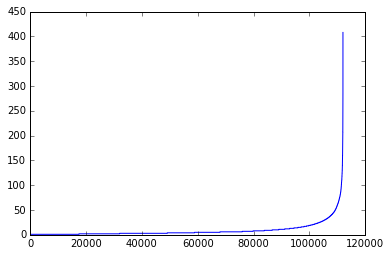

In [13]:
cdict = {}
for q in queues_id:
    for sid in q:
        if sid not in cdict:
            cdict[sid] =0
        cdict[sid] += 1        

plt.plot(sorted(v for k,v in cdict.items()))
sum(1 for sid,c in cdict.items() if c >= 5)

In [14]:
# !pip install --upgrade gensim

# import gensim

In [15]:
sids = list(set(sid for q in queues_id for sid in q))
sid2md = dict((sid,md) for q in queues for md,sid in q)

genres = set(md[2] for q in queues_md for md in q)
idx2genre = dict(enumerate(genres))
genre2idx = dict((g,i) for i,g in enumerate(genres))

In [269]:
artists = set(md[1] for q in queues_md for md in q)
idx2artist = dict(enumerate(artists))
artist2idx = dict((a,i) for i,a in enumerate(artists))

In [270]:
artcdict = dict((a,0) for a in artists)
for q in queues_md:
    for md in q:
        artcdict[md[1]] += 1

In [431]:
thresh = 1000
artists = [a for a,c in artcdict.items() if c > thresh]
idx2artist = dict(enumerate(artists))
artist2idx = dict((a,i) for i,a in enumerate(artists))

In [432]:
len(artists)

168

### Todo
- [ ] test occurrence count models - b/c window set to max sentence lenght
    - [ ] LDA
    - [ ] LSI
    - [ ] SVD

In [433]:
%%time
w2vembdim = 64
songid_model = gensim.models.Word2Vec(sentences=queues_id,size=w2vembdim,window=200,min_count=5)
# songid_model = gensim.models.LsiModel(corpus=queues_id,num_topics=200)

CPU times: user 53.4 s, sys: 1.07 s, total: 54.4 s
Wall time: 26 s


In [434]:
sids = np.array(list(songid_model.wv.vocab.keys()))
smd = np.array([sid2md[sid] for sid in sids])
sgenre = np.array([md[2] for md in smd])
# sp.spa
sgenre1hot = np.eye(len(genres))[np.array([genre2idx[g] for g in sgenre])]
sartist = np.array([md[1] for md in smd])
data = [1]*(len(sartist))
row = range(len(sartist))
col = [artist2idx[a] if a in artist2idx else len(artists) 
       for a in sartist]
sartist1hot = sp.sparse.csr_matrix((data,(row,col)))
# sartist1hot = np.eye(len(artists))[np.array([artist2idx[a] for a  in sartist])]
svec = np.array([songid_model.wv[sid] for sid in sids])
syear[syear == None] = np.mean(syear[syear!=None])
syear = syear.astype(float)
syear -= np.mean(syear)

In [435]:
print(sartist1hot.shape,len(artists))

(53230, 169) 168


In [488]:
X = ks.Input(shape=svec.shape[1:])

Z1 = ks.layers.Dense(units=100)(X)
A1 = ks.layers.Activation('relu')(Z1)

nnembdim = 16
Z2 = ks.layers.Dense(units=nnembdim)(Z1)
A2 = ks.layers.Activation('tanh')(Z2)

# GENRE PREDICTION
Z3 = ks.layers.Dense(units=100)(A2)
A3 = ks.layers.Activation('relu')(Z3)

Z4 = ks.layers.Dense(units=len(genres))(A3)
Y = ks.layers.Activation('softmax')(Z4)

# YEAR PREDICTION
Z3y = ks.layers.Dense(units=100)(A2)
A3y = ks.layers.Activation('relu')(Z3y)

Yy = ks.layers.Dense(units=1)(A3y)
# Yy = ks.layers.Activation('relu')(Z4y)

# ARTIST PREDICTION
Z3a = ks.layers.Dense(units=100)(A2)
A3a = ks.layers.Activation('relu')(Z3a)

Z4a = ks.layers.Dense(units=len(artists)+1)(A3a)
Ya = ks.layers.Activation('softmax')(Z4a)

In [489]:
trainEmb = ks.models.Model(inputs=[X],outputs=[Y])
opt = ks.optimizers.Adam(lr=0.01)
loss = ks.losses.categorical_crossentropy
trainEmb.compile(optimizer=opt,loss=loss,metrics=['accuracy'])

In [490]:
trainEmby = ks.models.Model(inputs=[X],outputs=[Yy])
opt = ks.optimizers.Adam(lr=0.01)
loss = ks.losses.mean_squared_error
trainEmby.compile(optimizer=opt,loss=loss)

In [491]:
trainEmba = ks.models.Model(inputs=[X],outputs=[Ya])
opt = ks.optimizers.Adam(lr=0.01)
loss = ks.losses.categorical_crossentropy
trainEmba.compile(optimizer=opt,loss=loss,metrics=['accuracy'])
def batchGen(X,y,batch_size):
    n_batches = X.shape[0] // batch_size
    randidx = list(range(X.shape[0]))
    while True:
        np.random.shuffle(randidx)
        for i in range(n_batches):
            batchidx = randidx[i*batch_size:(i+1)*batch_size]
            Xb = X[batchidx,:]
            yb = y[batchidx,:].toarray()
            yield(Xb,yb)

In [492]:
for i in range(10):
#     perf = trainEmb.evaluate(x=[svec],y=[sgenre1hot],batch_size=2048)
#     print(perf)
#     hist = trainEmb.fit(x=[svec],y=[sgenre1hot],batch_size=2048,epochs=2)
    
    perf = trainEmby.evaluate(x=[svec],y=[syear],batch_size=2048)
    print(perf)
    hist = trainEmby.fit(x=[svec],y=[syear],batch_size=2048,epochs=2)
    
#     perf = trainEmba.evaluate(x=[svec],y=[sartist1hot.toarray()],batch_size=2048)
#     print(perf)
#     hist = trainEmba.fit(x=[svec],y=[sartist1hot.toarray()],batch_size=2048,epochs=2)
# #     artbatchsz = 128
# #     hist = trainEmba.fit_generator(generator=batchGen(svec,sartist1hot,artbatchsz),
# #                                    epochs=2,
# #                                    steps_per_epoch=svec.shape[0]//artbatchsz)

53230/53230 [==============================] - 6s 106us/step
188.7766141597297
Epoch 1/2
53230/53230 [==============================] - 6s 111us/step - loss: 121.0970
Epoch 2/2
53230/53230 [==============================] - 0s 5us/step
90.87880649914223
Epoch 1/2
53230/53230 [==============================] - 0s 7us/step - loss: 90.1944
Epoch 2/2
53230/53230 [==============================] - 0s 4us/step
87.80461157584311
Epoch 1/2
53230/53230 [==============================] - 0s 7us/step - loss: 87.9156
Epoch 2/2
53230/53230 [==============================] - 0s 4us/step
87.82277383755948
Epoch 1/2
53230/53230 [==============================] - 0s 8us/step - loss: 87.5086
Epoch 2/2
53230/53230 [==============================] - 0s 4us/step
86.81422993245931
Epoch 1/2
53230/53230 [==============================] - 0s 6us/step - loss: 87.4739
Epoch 2/2
53230/53230 [==============================] - 0s 4us/step
86.92037542107722
Epoch 1/2
53230/53230 [==============================] - 0

In [493]:
getEmb = ks.models.Model(inputs=[X],outputs=[A2])
nnemb = getEmb.predict(x=[svec])
nnemb_wv = dict(zip(sids,nnemb))

In [494]:
# idx2sid = dict(enumerate([sid for sid in sids if sid in songid_model.wv]))
# sid2idx = dict((sid,i) for i,sid in idx2sid.items())
idx2sid = dict(enumerate([sid for sid in sids if sid in nnemb_wv]))
sid2idx = dict((sid,i) for i,sid in idx2sid.items())

In [495]:
# msids = [sid for sid in usids if sid in songid_model.wv]
# X = np.array([songid_model.wv[sid] for sid in msids])
# Xmd = np.array([sid2md[sid] for sid in msids])
msids = [sid for sid in usids if sid in nnemb_wv]
Xvec = np.array([nnemb_wv[sid] for sid in msids])
Xmd = np.array([sid2md[sid] for sid in msids])

In [496]:
Xvec.shape

(540, 16)

In [501]:
if Xvec.shape[1] > 2:
    X2d = sklearn.decomposition.PCA(n_components=2).fit_transform(Xvec)
else:
    X2d = Xvec

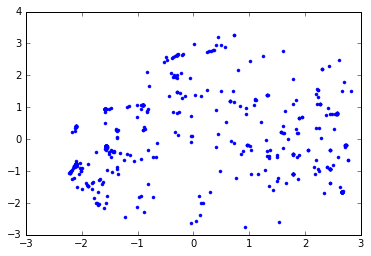

In [502]:
plt.plot(X2d[:,0],X2d[:,1],'.')

In [503]:
n_clusters = len(msids)//20
n_clusters

27

In [504]:
# clst = sklearn.cluster.KMeans(n_clusters=n_clusters) # Good
# clst = sklearn.cluster.AffinityPropagation() # OK
# clst = sklearn.cluster.Birch(n_clusters=n_clusters) # Great
# clst = sklearn.cluster.DBSCAN() # didn't get all but Good
# clst = sklearn.mixture.GaussianMixture(n_components=n_clusters) # ok
clst = sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters) # Great
try:
    labels = clst.fit_predict(Xvec)
except:
    clst.fit(X)
    labels = clst.predict(Xvec)

### TODO
- [ ] looks like w2vec embeddings not ideal for this problem - try diff methods
    - [ ] lda
    - [ ] lsi
    - [ ] svd
- [x] MLP w/ song vec -> emb size -> ~100 -> SM -> genre clf
    - [x] get emb hidden layers activations w/ forward pass
    - [x] switch to sparse 1-hot
    - [x] include artist prediction task
        - [x] filter uncommon artists
        - [x] generate dense matrices in batches to avoid memory constraint - still 100x slowdown so do 2nd
    - [x] include year regression task
    - [ ] check validation err to monitor overfitting 
    - [ ] combine models -> classify [artist|genre|decade]
        - [ ] figure out how to weight different categories differently
    - [ ] multiple output functions - weight differently? - https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/
    - [ ] variational embedding layer - sup 32 dim is reasonable embedding dim
        - [ ] https://blog.keras.io/building-autoencoders-in-keras.html
- [ ] try VAE
- [ ] create evaluation metric
- [ ] create parameter variation process
- [ ] compare to sorting by genre/artist/year
- [ ] add rating,viewcount,etc.. to metadata
- [ ] source 'sentences' from somewhere else - clearly spinning radio stations up and down not viable
- [ ] for manipulating song stream
    - [ ] depthwise separable convolution
    - [ ] sparsity constraints w/ pruning
        - [ ] for RNN i.e. waveRNN
        - [ ] forn CNN - saw package online - https://github.com/jacobgil/pytorch-pruning
            - Note: supposedly not equally efficient to train

In [505]:
clusters = [[str(md) for md,j in zip(Xmd,labels) if j == i] for i in range(max(labels))]

In [506]:
sum(len(c) for c in clusters),Xmd.shape

(536, (540, 4))

In [507]:
sorted(len(cluster) for cluster in clusters)

[7,
 9,
 10,
 10,
 11,
 11,
 12,
 12,
 13,
 13,
 14,
 15,
 15,
 15,
 16,
 17,
 18,
 19,
 21,
 25,
 27,
 29,
 43,
 44,
 48,
 62]

In [508]:
for i,cluster in sorted(enumerate(clusters),key=lambda tup: -len(tup[1])):
    print(i)
    print(len(cluster))
    print("\n".join(cluster))
    print()

3
62
['Hypocrite' 'Cage The Elephant' "'10s Alternative" 2013]
['Sweetie Little Jean' 'Cage The Elephant' 'Alternative/Indie' 2015]
['Halo' 'Cage The Elephant' "'10s Alternative" 2013]
['In One Ear' 'Cage The Elephant' "'00s Alternative" 2008]
['Tidal Wave' 'Portugal. The Man' 'Alternative/Indie' 2017]
['The Sun' 'Portugal. The Man' "'00s Alternative" 2009]
['Senseless' 'Portugal. The Man' "'10s Alternative" 2011]
["I Guess I'm Floating" 'M83' 'Electropop' 2005]
['Holy Roller (Hallelujah)' 'Portugal. The Man' "'10s Alternative" 2013]
['Outro' 'M83' 'Electropop' 2011]
['Someday Believers' 'Portugal. The Man' "'10s Alternative" 2013]
['Do You' 'Portugal. The Man' "'00s Alternative" 2009]
['People Say' 'Portugal. The Man' "'00s Alternative" 2009]
['Hip Hop Kids (feat. John Baldwin Gourley)' 'Portugal. The Man'
 "'10s Alternative" 2013]
['Rubber Ball' 'Cage The Elephant' "'10s Alternative" 2011]
['Shake Me Down' 'Cage The Elephant' "'10s Alternative" 2011]
['Spiderhead' 'Cage The Elephant'

In [ ]:
if all_song
    api.delete_playlist(allsongs_id)
except:
    pass
allsongs_id_new = api.create_playlist(allsongs_name)
api.add_songs_to_playlist(allsongs_id_new,list(set(ids)))